In [297]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

plt.style.use(['ggplot'])
%matplotlib inline

In [298]:
class GradientDescent():
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate: float = learning_rate
        self.iterations: int = iterations
        self.dataset: pd.DataFrame = None
        self.X_train: np.ndarray = None
        self.X_test: np.ndarray = None
        self.Y_train: np.ndarray = None
        self.Y_test: np.ndarray = None
        self.W: np.ndarray = None

    def fetch_dataset(self, url: str) -> None:
        """Fetch a csv dataset from a public url and store it in a pandas dataframe

        Args:
            url (str): oublic url to a csv dataset

        Returns:
            None
        """
        self.dataset = pd.read_csv(url)

    def fit(self):
        # check if dataset has been preprocessed
        if self.X_train is None:
            # preprocess the dataset with all the columns assuming the last column is the Y
            self.preprocess(self.dataset.columns[:-1], self.dataset.columns[-1])

        # gradient descent vector helper functions
        def generateXVector(X: np.ndarray) -> np.ndarray:
            newX = np.concatenate((np.ones((len(X), 1)), X), axis=1)
            return newX

        def generateYVector(Y: np.ndarray) -> np.ndarray:
            newY = np.reshape(Y, (len(Y), 1))
            return newY

        def generateWVector(X: np.ndarray) -> np.ndarray:
            w = np.zeros((len(X[0]), 1))
            return w

        # generate the X, Y and W vectors
        Y = generateYVector(self.Y_train)
        X = generateXVector(self.X_train)
        W = generateWVector(X)
        costs = []
        n = len(X)
        
        # print(f'X Shape: {X.shape}')
        # print(f'W Shape: {W.shape}')
        # print(f'Y Shape: {Y.shape}')

        # gradient descent algorithm
        for i in range(self.iterations):
            # calculate the gradients
            gradients = 2/n * X.T.dot(X.dot(W) - Y)
            # update the weights
            W = W - self.learning_rate * gradients
            predictedY = X.dot(W)
            # calculate the cost
            # J = 1/2n * sum( (h(x) - y)^2 )
            cost = 1/(2*len(Y))*((predictedY - Y)**2) 
            costs.append(cost.sum())
        self.W = W
        return costs
    
    def predict(self, X: np.ndarray, W: np.ndarray) -> np.ndarray:
        """Predict the Y values for a given X

        Args:
            X (np.ndarray): Vector of X values
            W (np.ndarray): Vector of weights

        Returns:
            np.ndarray: List of predicted Y values
        """
        newX = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        return newX.dot(W).flatten()

    def preprocess(self, X_columns: list, Y_column: str) -> None:
        """Preprocess the dataset by splitting it into X and Y and standardizing the X

        Args:
            X_columns (list): list of column names to be used as X
            Y_column (str): column name to be used as Y

        Returns:
            None
        """
        self.dataset = self.dataset.dropna(axis=0)
        self.dataset = self.dataset[X_columns + [Y_column]]
        
        X = self.dataset.drop(columns=Y_column)
        Y = self.dataset[Y_column]
        
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit(X).fit_transform(X))
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(
            X, Y, test_size=0.2, random_state=5)
        self.X_train = np.array(self.X_train)
        self.X_test = np.array(self.X_test)
        self.Y_train = np.array(self.Y_train)
        self.Y_test = np.array(self.Y_test)

    def rename_dataset_columns(self, columns: dict[str: str]):
        """Rename the dataset columns

        Args:
            columns (list): list of column names

        Returns:
            None
        """
        self.dataset.rename(columns=columns, inplace=True)

class Analysis():

    def plot_data(self, labels: dict[str: str], X: np.ndarray, Y: np.ndarray, W=None, label="") -> None:
        """Plot the data in a grid by feature"""
        fig = plt.figure(figsize=(30,20))
        fig.suptitle(label, fontsize=30)

        plot_w = 1 if len(labels) <= 2 else 2
        plot_h = math.ceil(len(labels) / plot_w)
        font = 22 if plot_w == 1 else 16
        plt.rcParams.update({'font.size': font})
        for i, (x, y) in enumerate(labels.items()):
            plt.subplot(plot_h, plot_w, i+1)
            plt.plot(X[:, i], Y, 'b.')
            if W is not None:
                X_plot = X[:, i]
                Y_plot = np.concatenate((np.ones((len(X), 1)), X), axis=1).dot(W)
                plt.plot(X_plot, Y_plot, 'r.')
            plt.ylabel(y, fontsize=font+2)
            plt.xlabel(x, fontsize=font+2)
        plt.show()

    def info(self, Y_real: np.ndarray, Y_pred: np.ndarray):
        mse = mean_squared_error(Y_real, Y_pred)
        r2 = r2_score(Y_real, Y_pred)
        variance = explained_variance_score(Y_real, Y_pred)
        print("--------------------------------------")
        print('MSE is {}'.format(mse))
        print('R2 score is {}'.format(r2))
        print('Explained Variance score is {}'.format(variance))
        print("--------------------------------------")


In [299]:
# initialize the gradient descent class
gd = GradientDescent(iterations=3000, learning_rate=0.001)
print("Fetching dataset... ", end="")
gd.fetch_dataset('https://raw.githubusercontent.com/NorthPhoenix/ML-Gradual_Descent_Algorithm/main/dataset/Tetuan%20City%20power%20consumption.csv')
print("Done")

Fetching dataset... Done


In [300]:

# preprocess the dataset
print("Preprocessing dataset... ", end="")
gd.rename_dataset_columns(
    {'Zone 1 Power Consumption': 'Power', 'Temperature': 'Temp', 'Wind Speed': 'Wind', 'general diffuse flows': 'Gen_Dif_Flow', 'diffuse flows': 'Dif_Flow'})
features = ['Temp', 'Humidity', 'Gen_Dif_Flow']
label = 'Power'
gd.preprocess(features, label)
print("Done")

# analysis = Analysis()
# analysis.plot(dict.fromkeys(features, label), gd.X_train, gd.Y_train, label="Features vs Label")

Preprocessing dataset... Done


In [301]:

# train the model
print("Training model... ", end="")
costs = gd.fit()
print("Done")


Training model... Done


In [302]:
# predict the train set
Y_train_pred = gd.predict(gd.X_train, gd.W)
Y_test_pred = gd.predict(gd.X_test, gd.W)

# initialize the SGD regressor
sgd_regressor = SGDRegressor()
# train the model
sgd_regressor.fit(gd.X_train, gd.Y_train)
# predict the test set
SK_Y_train_pred = sgd_regressor.predict(gd.X_train)
SK_Y_test_pred = sgd_regressor.predict(gd.X_test)


My model's performance for training set
--------------------------------------
MSE is 40539246.520671114
R2 score is 0.20525434483359828
Explained Variance score is 0.20537949239746778
--------------------------------------
My model's performance for test set
--------------------------------------
MSE is 39871837.25689568
R2 score is 0.20531139627020445
Explained Variance score is 0.2053151388991591
--------------------------------------


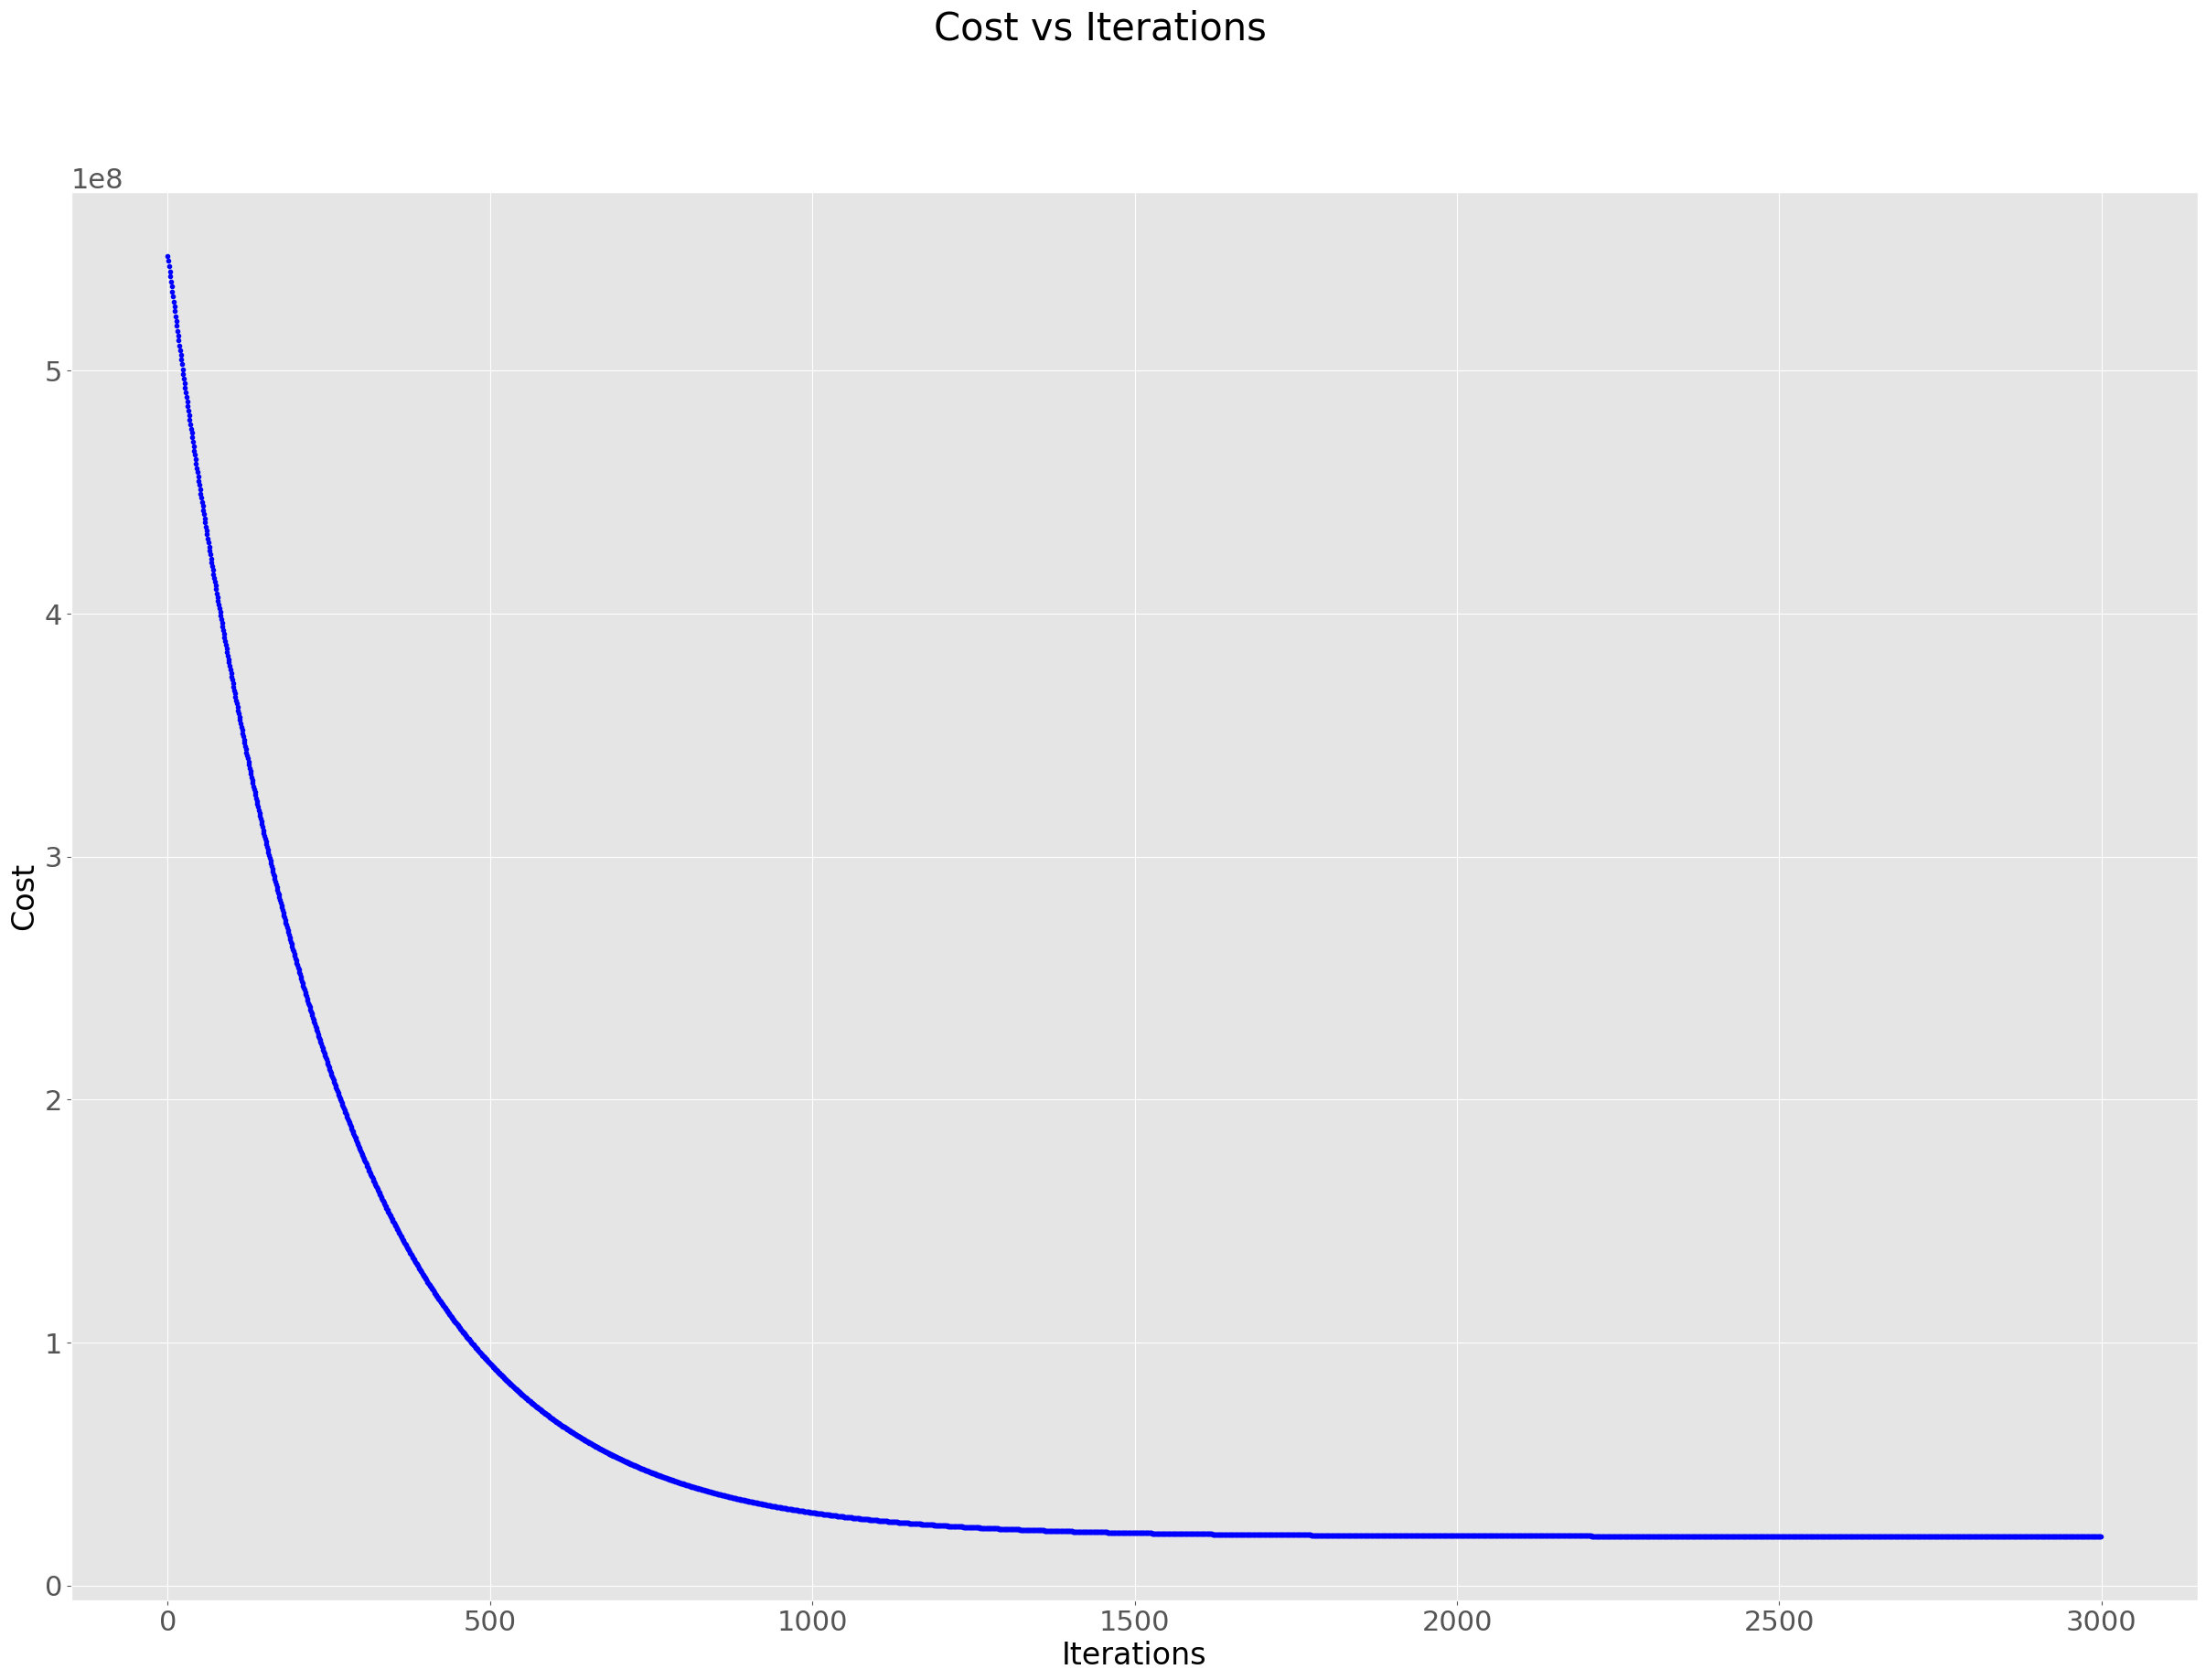

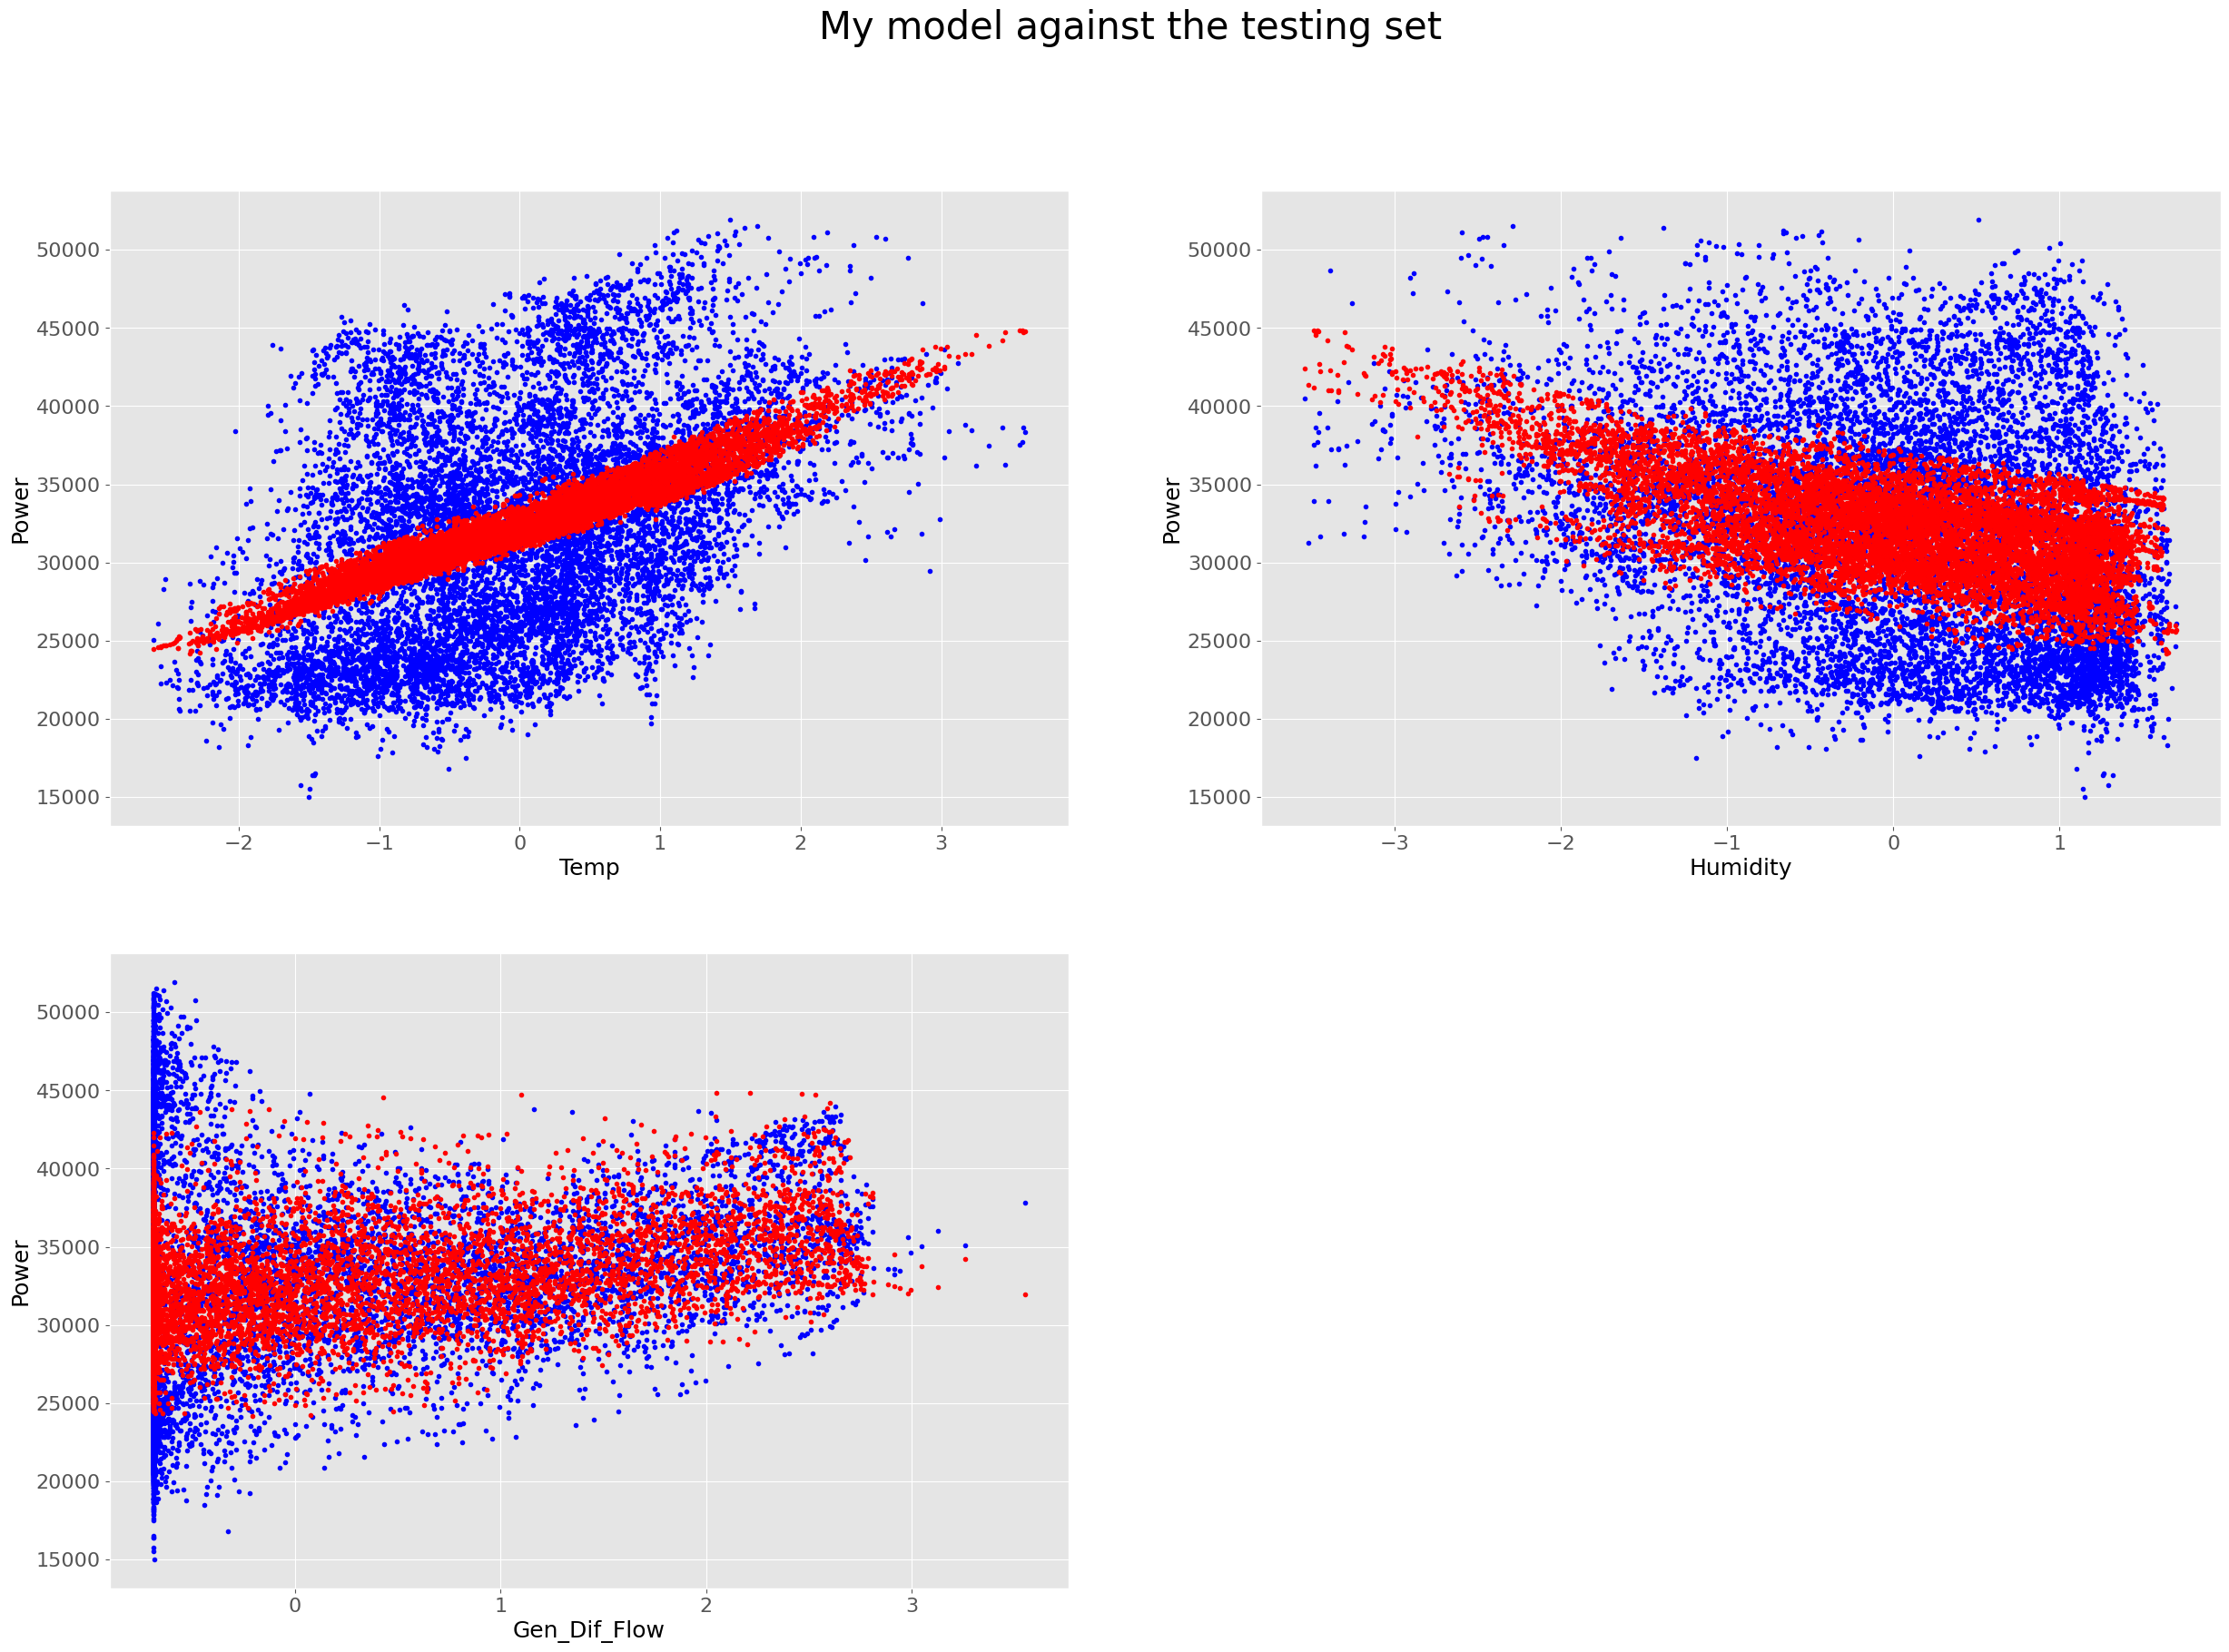

In [303]:

analysis = Analysis()

print("My model's performance for training set")
analysis.info(gd.Y_train, Y_train_pred)
print("My model's performance for test set")
analysis.info(gd.Y_test, Y_test_pred)
# print("SKLearn model's performance for training set")
# analysis.info(gd.Y_train, SK_Y_train_pred)
# print("SKLearn model's performance for test set")
# analysis.info(gd.Y_test, SK_Y_test_pred)

analysis.plot_data({'Iterations': 'Cost'}, np.arange(len(costs)).reshape(len(costs), 1), costs, label='Cost vs Iterations')
analysis.plot_data(dict.fromkeys(features, label), gd.X_test, gd.Y_test, W=gd.W, label='My model against the testing set')
# analysis.plot(dict.fromkeys(features, label), gd.X_test, gd.Y_test, W=np.hstack((sgd_regressor.intercept_, sgd_regressor.coef_)), label='SKLearn model on the testing set')
